In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Vision Libraries
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
BASE_PATH = '/kaggle/input/aptos2019/'
TRAIN_CSV = os.path.join(BASE_PATH, 'train_1.csv')
VAL_CSV = os.path.join(BASE_PATH, 'valid.csv')
TRAIN_DIR = os.path.join(BASE_PATH, 'train_images/train_images')
VAL_DIR = os.path.join(BASE_PATH, 'val_images/val_images')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 30
MIXUP_ALPHA = 1.0

In [ ]:
# 3. --- AUGMENTATIONS ---
# A robust set of augmentations for this task
train_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
class DRDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index]['id_code'] + '.png'
        label = self.df.iloc[index]['diagnosis']
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label


In [ ]:
class HybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridModel, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0)

        self.fusion = nn.Sequential(
            nn.Linear(self.efficientnet.num_features + self.resnet.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feat1 = self.efficientnet(x)
        feat2 = self.resnet(x)
        combined = torch.cat((feat1, feat2), dim=1)
        out = self.fusion(combined)
        return out

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
if __name__ == '__main__':
    # Load dataframes
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)

    # Create datasets and dataloaders
    train_dataset = DRDataset(train_df, TRAIN_DIR, transform=train_transform)
    val_dataset = DRDataset(val_df, VAL_DIR, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Class weights for imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['diagnosis']),
        y=train_df['diagnosis']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
# Initialize model, loss, optimizer, scheduler
    model = HybridModel(num_classes=5).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

    print("--- Starting Training ---")
    print(f"Device: {DEVICE}")
    print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}")
    print(f"Using Mixup with alpha = {MIXUP_ALPHA}")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

--- Starting Training ---
Device: cuda
Epochs: 30, Batch Size: 32, Learning Rate: 0.0001
Using Mixup with alpha = 1.0


In [ ]:
for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Mixup
            lam = np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA)
            rand_index = torch.randperm(images.size(0))
            images_b, labels_b = images[rand_index], labels[rand_index]
            mixed_images = lam * images + (1 - lam) * images_b

            optimizer.zero_grad()
            outputs = model(mixed_images)
            loss = mixup_criterion(criterion, outputs, labels, labels_b, lam)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 1/30, Loss: 1.2274


Epoch 2/30: 100%|██████████| 92/92 [02:37<00:00,  1.71s/it]


Epoch 2/30, Loss: 1.2671


Epoch 3/30: 100%|██████████| 92/92 [02:32<00:00,  1.66s/it]


Epoch 3/30, Loss: 1.2571


Epoch 4/30: 100%|██████████| 92/92 [02:34<00:00,  1.67s/it]


Epoch 4/30, Loss: 1.2097


Epoch 5/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 5/30, Loss: 1.2673


Epoch 6/30: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 6/30, Loss: 1.2304


Epoch 7/30: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 7/30, Loss: 1.2541


Epoch 8/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 8/30, Loss: 1.2596


Epoch 9/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 9/30, Loss: 1.2398


Epoch 10/30: 100%|██████████| 92/92 [02:32<00:00,  1.66s/it]


Epoch 10/30, Loss: 1.2444


Epoch 11/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 11/30, Loss: 1.2277


Epoch 12/30: 100%|██████████| 92/92 [02:35<00:00,  1.70s/it]


Epoch 12/30, Loss: 1.2306


Epoch 13/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 13/30, Loss: 1.1906


Epoch 14/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 14/30, Loss: 1.2444


Epoch 15/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 15/30, Loss: 1.2295


Epoch 16/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 16/30, Loss: 1.2122


Epoch 17/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 17/30, Loss: 1.2257


Epoch 18/30: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 18/30, Loss: 1.2182


Epoch 19/30: 100%|██████████| 92/92 [02:34<00:00,  1.67s/it]


Epoch 19/30, Loss: 1.2118


Epoch 20/30: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 20/30, Loss: 1.2096


Epoch 21/30: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 21/30, Loss: 1.1946


Epoch 22/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 22/30, Loss: 1.2042


Epoch 23/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 23/30, Loss: 1.2520


Epoch 24/30: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 24/30, Loss: 1.2192


Epoch 25/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 25/30, Loss: 1.2214


Epoch 26/30: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 26/30, Loss: 1.2510


Epoch 27/30: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 27/30, Loss: 1.2104


Epoch 28/30: 100%|██████████| 92/92 [02:32<00:00,  1.66s/it]


Epoch 28/30, Loss: 1.1781


Epoch 29/30: 100%|██████████| 92/92 [02:31<00:00,  1.65s/it]


Epoch 29/30, Loss: 1.1894


Epoch 30/30: 100%|██████████| 92/92 [02:31<00:00,  1.65s/it]

Epoch 30/30, Loss: 1.1760



--- Validation Metrics for Epoch 30 ---
                  precision    recall  f1-score   support

           No DR       0.99      0.99      0.99       172
            Mild       0.64      0.75      0.69        40
        Moderate       0.79      0.65      0.72       104
          Severe       0.42      0.68      0.52        22
Proliferative DR       0.73      0.68      0.70        28

        accuracy                           0.83       366
       macro avg       0.71      0.75      0.72       366
    weighted avg       0.84      0.83      0.83       366



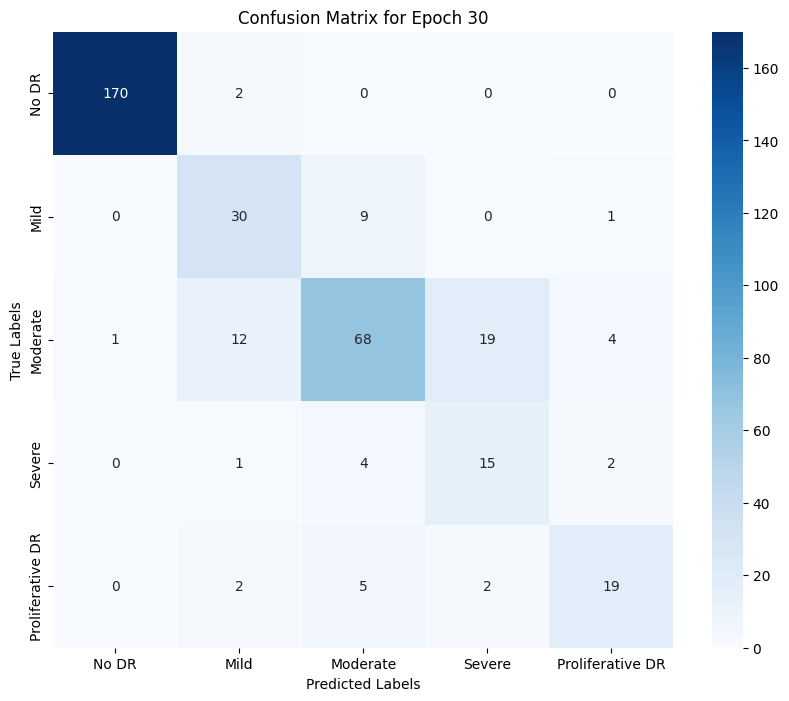

--- Training complete. ---


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"\n--- Validation Metrics for Epoch {epoch+1} ---")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for Epoch {epoch+1}')
plt.show()

print("--- Training complete. ---")


In [ ]:
# 1. --- IMPORTS ---
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ML and Vision Libraries
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

# 2. --- SETUP PATHS AND CONFIGURATION ---
BASE_PATH = '/kaggle/input/aptos2019/'
TRAIN_CSV = os.path.join(BASE_PATH, 'train_1.csv')
VAL_CSV = os.path.join(BASE_PATH, 'valid.csv')
TRAIN_DIR = os.path.join(BASE_PATH, 'train_images/train_images')
VAL_DIR = os.path.join(BASE_PATH, 'val_images/val_images')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 40
MIXUP_ALPHA = 1.0
NUM_CLASSES = 5

# 3. --- AUGMENTATIONS ---
train_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 4. --- DATASET CLASS ---
class DRDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index]['id_code'] + '.png'
        label = self.df.iloc[index]['diagnosis']
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

# 5. --- HYBRID MODEL ---
class HybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridModel, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0)

        self.fusion = nn.Sequential(
            nn.Linear(self.efficientnet.num_features + self.resnet.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feat1 = self.efficientnet(x)
        feat2 = self.resnet(x)
        combined = torch.cat((feat1, feat2), dim=1)
        out = self.fusion(combined)
        return out

# 6. --- FOCAL LOSS (Alternative to BCE) ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

# 7. --- MAIN EXECUTION ---
if __name__ == '__main__':
    # Load data
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)

    # Datasets & loaders
    train_dataset = DRDataset(train_df, TRAIN_DIR, transform=train_transform)
    val_dataset = DRDataset(val_df, VAL_DIR, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = HybridModel(num_classes=NUM_CLASSES).to(DEVICE)

    # Class weights (for imbalance)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['diagnosis']),
        y=train_df['diagnosis']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

    # Loss (choose one)
    criterion = nn.BCEWithLogitsLoss(weight=class_weights)   # soft-label BCE
    # criterion = FocalLoss(alpha=1, gamma=2)                # alternative focal loss

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

    print("--- Starting Training ---")

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # One-hot labels for BCE
            labels_onehot = F.one_hot(labels, num_classes=NUM_CLASSES).float()

            # Mixup
            lam = np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA)
            rand_index = torch.randperm(images.size(0))
            images_b, labels_b = images[rand_index], labels_onehot[rand_index]
            mixed_images = lam * images + (1 - lam) * images_b
            mixed_labels = lam * labels_onehot + (1 - lam) * labels_b

            optimizer.zero_grad()
            outputs = model(mixed_images)
            loss = criterion(outputs, mixed_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

        # --- Validation ---


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


--- Starting Training ---


Epoch 1/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 1/40, Loss: 0.6009


Epoch 2/40: 100%|██████████| 92/92 [02:37<00:00,  1.72s/it]


Epoch 2/40, Loss: 0.4896


Epoch 3/40: 100%|██████████| 92/92 [02:37<00:00,  1.71s/it]


Epoch 3/40, Loss: 0.4670


Epoch 4/40: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 4/40, Loss: 0.4531


Epoch 5/40: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 5/40, Loss: 0.4347


Epoch 6/40: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 6/40, Loss: 0.4233


Epoch 7/40: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 7/40, Loss: 0.4195


Epoch 8/40: 100%|██████████| 92/92 [02:37<00:00,  1.71s/it]


Epoch 8/40, Loss: 0.4089


Epoch 9/40: 100%|██████████| 92/92 [02:37<00:00,  1.71s/it]


Epoch 9/40, Loss: 0.3993


Epoch 10/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 10/40, Loss: 0.4043


Epoch 11/40: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 11/40, Loss: 0.3947


Epoch 12/40: 100%|██████████| 92/92 [02:36<00:00,  1.71s/it]


Epoch 12/40, Loss: 0.3979


Epoch 13/40: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 13/40, Loss: 0.3859


Epoch 14/40: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 14/40, Loss: 0.3941


Epoch 15/40: 100%|██████████| 92/92 [02:34<00:00,  1.67s/it]


Epoch 15/40, Loss: 0.3791


Epoch 16/40: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 16/40, Loss: 0.3681


Epoch 17/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 17/40, Loss: 0.3702


Epoch 18/40: 100%|██████████| 92/92 [02:34<00:00,  1.68s/it]


Epoch 18/40, Loss: 0.3705


Epoch 19/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 19/40, Loss: 0.3473


Epoch 20/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 20/40, Loss: 0.3661


Epoch 21/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 21/40, Loss: 0.3513


Epoch 22/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 22/40, Loss: 0.3579


Epoch 23/40: 100%|██████████| 92/92 [02:37<00:00,  1.71s/it]


Epoch 23/40, Loss: 0.3533


Epoch 24/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 24/40, Loss: 0.3384


Epoch 27/40: 100%|██████████| 92/92 [02:38<00:00,  1.73s/it]


Epoch 27/40, Loss: 0.3235


Epoch 28/40: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 28/40, Loss: 0.3397


Epoch 29/40: 100%|██████████| 92/92 [02:36<00:00,  1.70s/it]


Epoch 29/40, Loss: 0.3438


Epoch 30/40: 100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


Epoch 30/40, Loss: 0.3346


Epoch 31/40: 100%|██████████| 92/92 [02:35<00:00,  1.69s/it]


Epoch 31/40, Loss: 0.3373


Epoch 32/40:  70%|██████▉   | 64/92 [01:49<00:39,  1.42s/it]

In [ ]:
torch.save(model.state_dict(), "hybrid_model_incomplete.pth")


In [ ]:
model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        print(f"\n--- Validation Metrics for Epoch {epoch+1} ---")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for Epoch {epoch+1}')
        plt.show()
